In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import json
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load nodes and edges from JSON file

In [4]:
nodes = json.load(open('./genshin_data/node_list.json', 'rb'))
edges = json.load(open('./genshin_data/edge_list.json', 'rb'))

In [5]:
 # example look of the node_list JSON file
nodes[1]

{'id': 'Keqing', 'nation': 'Liyue'}

In [6]:
# example look of the edge_list JSON file
edges[1]

{'type': 'voice', 'from': 'Amber', 'to': 'Klee'}

In [7]:
%%time

# create directed graph
directed_graph = nx.DiGraph()

# add characters with a nation attribute
for node in nodes:
    directed_graph.add_node(node['id'], nation=node['nation'])

# add character relations
for edge in edges:
    directed_graph.add_edge(edge['from'], edge['to'], type=edge['type'])

Wall time: 1.62 ms


In [8]:
# basic node and edge stats from networkx
print("Number of nodes:", directed_graph.number_of_nodes())
print("Number of edges:", directed_graph.number_of_edges())

Number of nodes: 35
Number of edges: 262


### In the Genshin Impact character network, we have 35 character nodes and 262 connections.

In [10]:
# setting node colours for drawing
nation_color_dict = {
    'Mondstadt': '#aff8db',
    'Liyue': '#ffcbc1',
    'Inazuma': '#d5aaff',
    'Snezhnaya': '#ace7ff'
}

# for each node, assign the node a color based on the
# the color map dictionary if the nation is existed in 
# the color map dictionary
node_colors = []
for node, nation in list(directed_graph.nodes(data="nation")):
    if nation in nation_color_dict:
        node_colors.append(nation_color_dict[nation])
    else:
        node_colors.append('#FFA500') # traveler doesn't belong to any nation

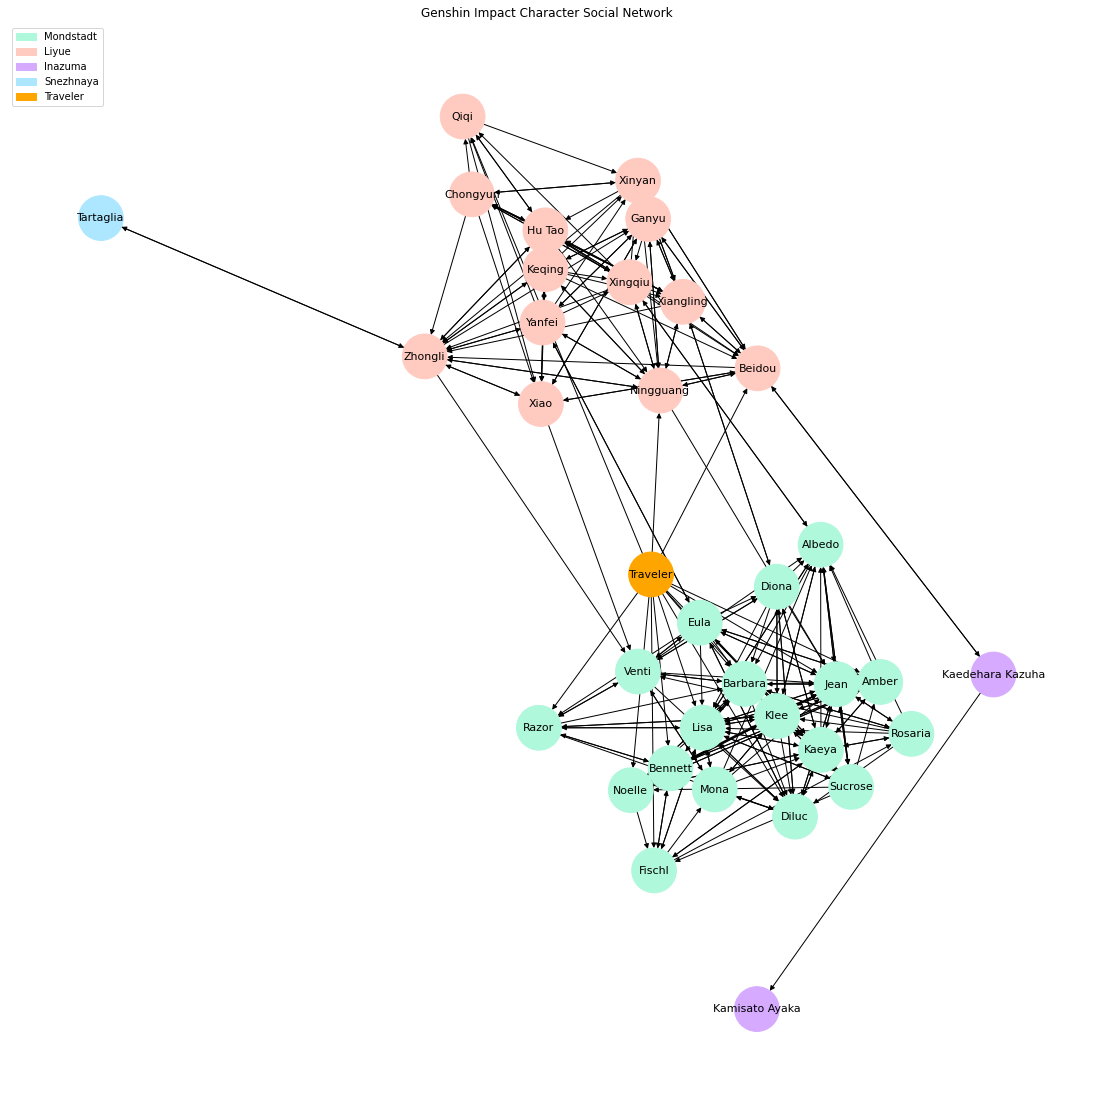

Wall time: 2.91 s


In [17]:
%%time

# create spring layout for 25 iterations to separate the nodes
np.random.seed(2021)
pos = nx.spring_layout(directed_graph, k=0.3, iterations=25)

plt.figure(1,figsize=(15,15)) 
nx.draw(directed_graph,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya"),
                mpatches.Patch(color="#FFA500", label="Traveler"),
               ]

plt.title("Genshin Impact Character Social Network")
plt.legend(handles=legend_tiles, loc="upper left")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

## Description Statistics:

## 2. Tradic Closure
The tendency for people who share connections in a social network to become connected

### 2.1 Local Clustering Coefficient (LCC)

1. Definition: Fractions of pairs of the node’s friends are friends with each other
2. Interpretation: How likely a node’s friends are connected to each other

In [18]:
# get the local cluster coefficient dataframe
def get_local_cluster_coefficient(graph):
    LCC_df = pd.DataFrame(sorted(nx.clustering(graph).items(), 
                                 key=lambda item: -item[1]), 
                      columns=["node", "LCC"])
    return LCC_df

In [21]:
# find nodes with LCC score of > 0.5:
# means that > 50% of change a node n's friends are friends of each other
node_data = dict(directed_graph.nodes(data="nation"))
LCC_df = get_local_cluster_coefficient(directed_graph)
LCC_df["nation"] = [node_data[node] for node in LCC_df["node"]]

# output the dataframe of LCC
print(round(100 * len(LCC_df.query("LCC > 0.5")) / len(LCC_df), 1),
      "% of the nodes have Local Cluster Coefficients > 0.5")
LCC_df.query("LCC > 0.5")

31.4 % of the nodes have Local Cluster Coefficients > 0.5


,node,LCC,nation
0,Sucrose,0.691919,Mondstadt
1,Keqing,0.660920,Liyue
2,Noelle,0.640000,Mondstadt
3,Rosaria,0.611111,Mondstadt
4,Amber,0.609589,Mondstadt
5,Chongyun,0.598039,Liyue
6,Ganyu,0.594118,Liyue
7,Mona,0.572581,Mondstadt
8,Xinyan,0.546667,Liyue
9,Diluc,0.537415,Mondstadt


In [22]:
LCC_df.nation.value_counts()

Mondstadt    18
Liyue        13
Inazuma       2
Snezhnaya     1
NA            1
Name: nation, dtype: int64

### Based on the current LCC output, we can observe that Sucrose is the character with highest LCC = 0.69. It means that 69% of Sucrose's connections are also connected with of each other.

### Let's look at the sub graph with Sucrose's connections below:

In [23]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]

Neighbors of node Sucrose: ['Eula', 'Lisa', 'Noelle', 'Klee', 'Albedo', 'Fischl', 'Kaeya', 'Amber', 'Jean']


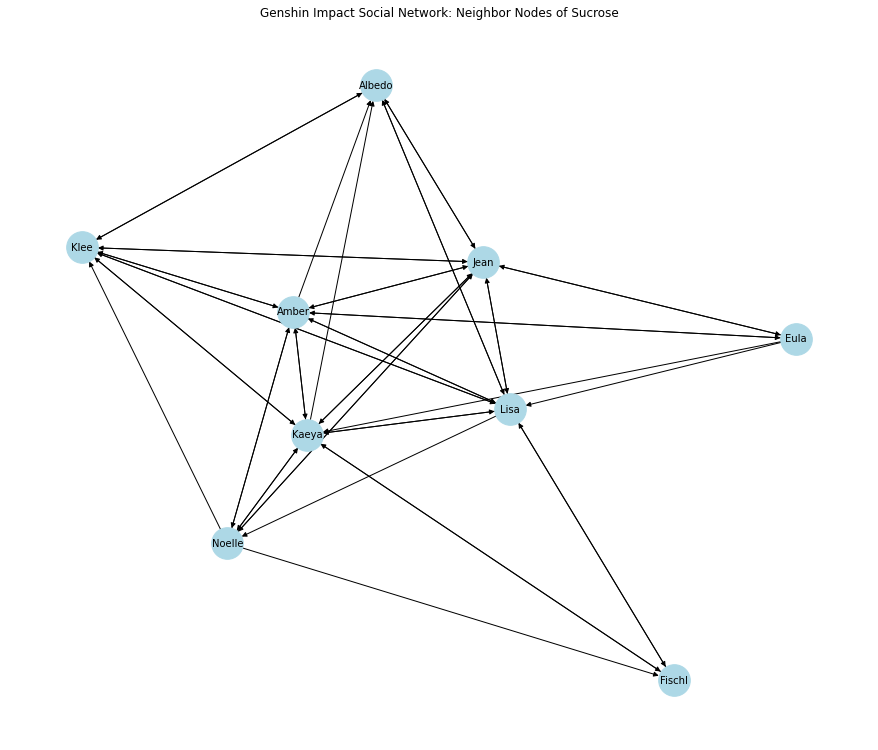

In [31]:
neighbor_nodes = get_neighbors(directed_graph, "Sucrose")
print("Neighbors of node Sucrose:", neighbor_nodes)

# get subgraph
subgraph = directed_graph.subgraph(neighbor_nodes)

# create visualization
pos = nx.spring_layout(subgraph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(12,10)) 
nx.draw(subgraph,
        pos = pos,
        node_size=1000,
        node_color="lightblue",
        with_labels=True,
        font_size = 10,
        font_color='black')
plt.title("Genshin Impact Social Network: Neighbor Nodes of Sucrose")
plt.show() 

### 2.2 Global Clustering Coefficient (GCC)

1. Definition: Measuring how likely the nodes are going to cluster on the whole network


### 2.2.2 Average local clustering coefficient: 
1. Definition: Average local clustering coefficient over all nodes in the graph.
2. Interpretation:  Overall, what’s the probability of adjacent nodes being connected.

In [32]:
# compute using the already calculated LCC dataframe
np.mean(LCC_df["LCC"])

0.4492437134000257

In [34]:
# compute using the average_clustering() function
nx.average_clustering(directed_graph)

0.44924371340002567

### Overall, the probability of adjacent nodes being connected is 44.92%, which is below 50%.

### 2.2.3 Transitivity:
1. Definition: Ratio of number of triangles and number of “open triads” in a network
2. Interpretation: Overall, what’s the probability of triangles formed over all the possible triangles in the network

In [35]:
nx.transitivity(directed_graph)

0.507007007007007

### Overall, the probability of triangles formed over all the possible triangles in the network is 50.7%

## 3. Connectivity:

### 3.1 Strongly connected: 
1. Definition: for every pair nodes u and v,there is 
    * a directed path from u to v and 
    * a directed path from v to u.
2. Interpretation: Are all the nodes reachable from every other node in the network?

In [41]:
# find whether a graph is strongly connected or not
print("Are all the nodes reachable from every other node in the network?",
      nx.is_strongly_connected(directed_graph))

Are all the nodes reachable from every other node in the network? False


### We can't reach all the nodes from every other node in the network. Because of this, we are unable to calculate the eccentricity because it requires checking all the path between any node a and any node b.

### 3.2 Weakly connected: 
1. Definition: a directed graph is weakly connected if replacing all directed edges with undirected edges produces a connected undirected graph

2. Interpretation: If not considering the direction of the connections, is the graph is connected?

In [42]:
# find whether a graph is weakly connected or not
print("If not considering the direction of the connections, is the graph is connected?",
      nx.is_weakly_connected(directed_graph))

If not considering the direction of the connections, is the graph is connected? True


### The directed graph is weakly connected. It means that there is only one connected component if we consider the graph as undirected.

## 4. Distance Measures

Measuring the length of the shortest path between a node A and a node B.

### 4.1 Average Distance (Average Shortest Path Length)
1. Definition: the average shortest path of all the connected node pairs
2. Interpretation: On average, how far away the nodes are from each other.

In [36]:
math.ceil(nx.average_shortest_path_length(directed_graph))

3

### On average,  the nodes are 3 steps from each other.

### 4.2 Eccentricity
1. Definition: For a node n, eccentricity is the largest distance between n and all other nodes
2. Interpretation: For each node, what’s the most far away distance to connect a node

In [43]:
# get the local cluster coefficient dataframe
def get_eccentricity_df(graph):
    try:
        nx.is_strongly_connected(directed_graph)
        eccentricity_df = pd.DataFrame(sorted(nx.eccentricity(graph).items(), 
                                       key=lambda item: -item[1]), 
                                       columns=["node", "eccentricity"])
        return eccentricty_df
    except:
        print("Unable to find eccentricity for not strongly connected directed graph")
        return []

In [44]:
# get sorted accentricty df
eccentricity_df = get_eccentricity_df(directed_graph)

Unable to find eccentricity for not strongly connected directed graph


### In the network, the network is not strongly connected. Hence, we can't find the eccentricty, radius, diameter, center, and periphery because the requirement for a graph being strongly connected.

## 5. Robustness Measures

The ability of a network to maintain its general structural properties when it faces failures or attacks.

### 5.1 Density
1. Definition: the ratio between the count of existing edges and all the possible edges’ count

2. Interpretation:
    * How many percent of the total possible edges are observed in a given network; help us understand how connected the network is compared to how connected it might be. 
    * Second, when comparing two networks with the same number of nodes and the same type of relationships, it can tell us how the networks are different.
    * Graphs with large node and edge connectivity are more robust to the loss of nodes and edges

In [48]:
nx.density(directed_graph)

0.22016806722689075

### The density of graph is 0.22. It implies the graph has 22% of the total possible edges are observed in the network. 

### 5.2 Node Connectivity and Minimum Node Cut:
1. Question: Minimum number of nodes to remove to disconnect a graph?
2. Which nodes can be removed to disconnect a graph?

In [49]:
nx.node_connectivity(directed_graph)

0

In [51]:
nx.minimum_node_cut(directed_graph)

set()

### Because of the network is not strongly connected, the minimum number of node to remove for disconnecting a graph is 0. Now, let's only look at nodes with mutual connections.

In [62]:
mutual_connection = directed_graph.to_undirected(reciprocal=True)

In [64]:
mutual_connection.degree()

DegreeView({'Xinyan': 3, 'Keqing': 4, 'Bennett': 6, 'Xiangling': 7, 'Zhongli': 6, 'Kaeya': 10, 'Klee': 10, 'Mona': 4, 'Yanfei': 5, 'Chongyun': 4, 'Diluc': 6, 'Kamisato Ayaka': 0, 'Ningguang': 7, 'Xingqiu': 4, 'Eula': 6, 'Beidou': 6, 'Albedo': 5, 'Amber': 7, 'Ganyu': 6, 'Barbara': 6, 'Rosaria': 3, 'Sucrose': 6, 'Hu Tao': 6, 'Kaedehara Kazuha': 1, 'Lisa': 11, 'Traveler': 0, 'Xiao': 4, 'Qiqi': 1, 'Venti': 5, 'Diona': 5, 'Fischl': 3, 'Noelle': 5, 'Razor': 4, 'Tartaglia': 1, 'Jean': 11})

In [99]:
# find isolates
isolates = list(nx.isolates(mutual_connection))
isolates

['Kamisato Ayaka', 'Traveler']

In [98]:
def get_directed_graph_node_degree(graph, node):
    print("\n- Degree statistics for", node)
    print(node, "in-degree:", graph.in_degree(node))
    print(node, "out-degree:", graph.out_degree(node))

get_directed_graph_node_degree(directed_graph, "Traveler")
get_directed_graph_node_degree(directed_graph, "Kamisato Ayaka")


- Degree statistics for Traveler
Traveler in-degree: 0
Traveler out-degree: 14

- Degree statistics for Kamisato Ayaka
Kamisato Ayaka in-degree: 1
Kamisato Ayaka out-degree: 0


### From the above isolate output, we can see Ayaka and Traveler don't have mutual connections like other characters. traveler mentioned other characters 14 times, but traveler is not mentioned by any existing character. Ayaka is mentioned by 1 character, but she didn't mention anyone else yet.

In [113]:
# create subgraph using the mutually connected nodes
mutual_connection.remove_nodes_from(isolates)

In [123]:
# get the mutual connection subgraph
mutual_connection_subgraph = directed_graph.subgraph(list(mutual_connection.nodes()))

In [124]:
# create node color list for visualization
mutual_connected_node_colors = []
for node, nation in list(mutual_connection_subgraph.nodes(data="nation")):
    if nation in nation_color_dict:
        mutual_connected_node_colors.append(nation_color_dict[nation])
    else:
        mutual_connected_node_colors.append('#FFA500') # traveler doesn't belong to any nation

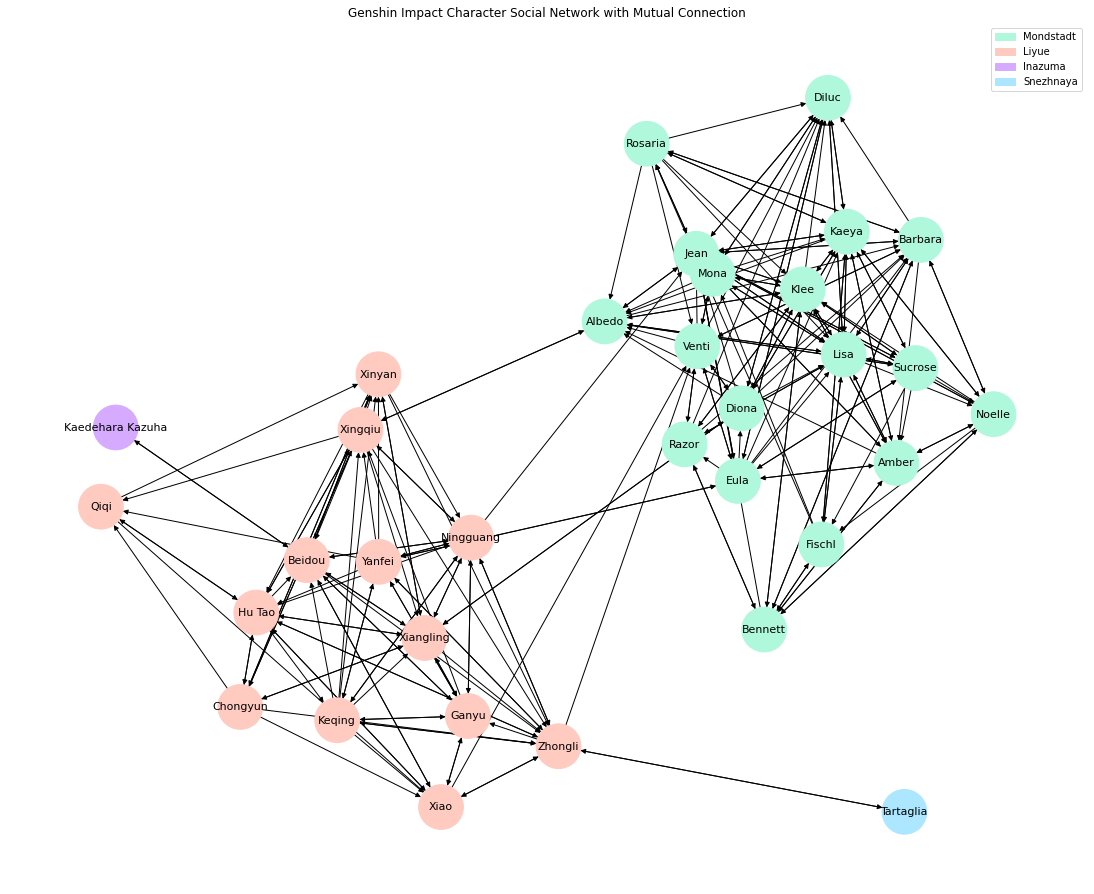

Wall time: 2.9 s


In [127]:
%%time

# create spring layout for 25 iterations to separate the nodes
pos = nx.spring_layout(mutual_connection_subgraph, k=0.5, iterations=25, seed=1)

plt.figure(1,figsize=(15,12)) 
nx.draw(mutual_connection_subgraph,
        pos = pos,
        node_size=2000,
        node_color=mutual_connected_node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya")
               ]

plt.title("Genshin Impact Character Social Network with Mutual Connection")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

### We can see Ayaka and Traveler are removed from the network because they don't have any mutual connection.

In [129]:
nx.node_connectivity(mutual_connection_subgraph)

1

In [131]:
nx.minimum_node_cut(mutual_connection_subgraph)

{'Beidou'}

### Seems like Beidou is the character that will disconnect the network. Let's make a copy of the network, and plot the graph after removing Beidou.

In [135]:
temp_copy = mutual_connection_subgraph.copy()
temp_copy.remove_nodes_from(["Beidou"])
temp_copy.nodes()

NodeView(('Xinyan', 'Keqing', 'Bennett', 'Xiangling', 'Zhongli', 'Kaeya', 'Klee', 'Mona', 'Yanfei', 'Chongyun', 'Diluc', 'Ningguang', 'Xingqiu', 'Eula', 'Albedo', 'Amber', 'Ganyu', 'Barbara', 'Rosaria', 'Sucrose', 'Hu Tao', 'Kaedehara Kazuha', 'Lisa', 'Xiao', 'Qiqi', 'Venti', 'Diona', 'Fischl', 'Noelle', 'Razor', 'Tartaglia', 'Jean'))

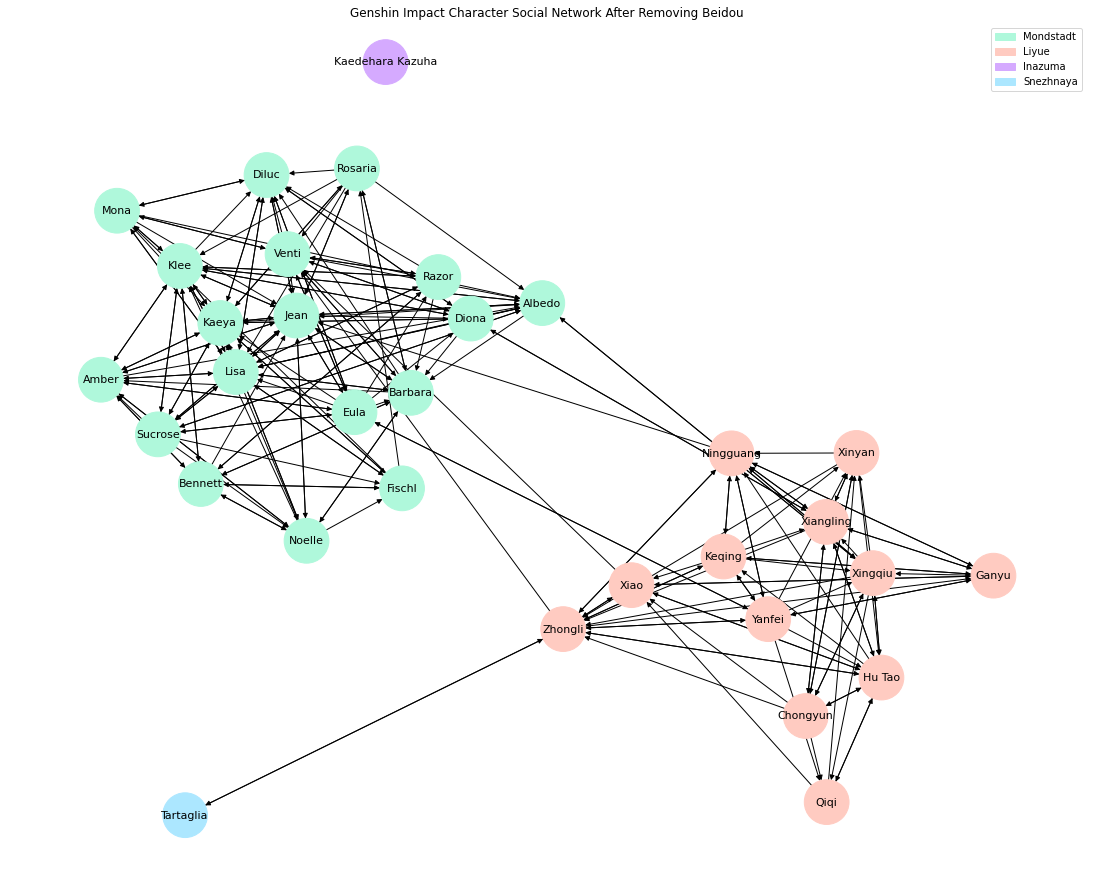

In [137]:
# create node color list for visualization
mutual_connected_node_colors = []
for node, nation in list(temp_copy.nodes(data="nation")):
    if nation in nation_color_dict:
        mutual_connected_node_colors.append(nation_color_dict[nation])
    else:
        mutual_connected_node_colors.append('#FFA500') # traveler doesn't belong to any nation
        
# create spring layout for 25 iterations to separate the nodes
pos = nx.spring_layout(temp_copy, k=0.5, iterations=25, seed=1)

plt.figure(1,figsize=(15,12)) 
nx.draw(temp_copy,
        pos = pos,
        node_size=2000,
        node_color=mutual_connected_node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya")
               ]

plt.title("Genshin Impact Character Social Network After Removing Beidou")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

### After removing Beidou, the connection between Beidou and Kazuha is removed. Hence, the network is disconnected. The same process can be applied to Zhongli to disconnect Tartaglia from the network.

### 5.2 Edge Connectivity and Minimum Edge Cut:
1. Question: Minimum number of edges to remove to disconnect a graph?
2. Which edges can be removed to disconnect a graph?

In [132]:
nx.edge_connectivity(mutual_connection_subgraph)

1

In [133]:
nx.minimum_edge_cut(mutual_connection_subgraph)

{('Tartaglia', 'Zhongli')}

In [142]:
temp_copy = mutual_connection_subgraph.copy()
temp_copy.remove_edges_from({('Tartaglia', 'Zhongli')})

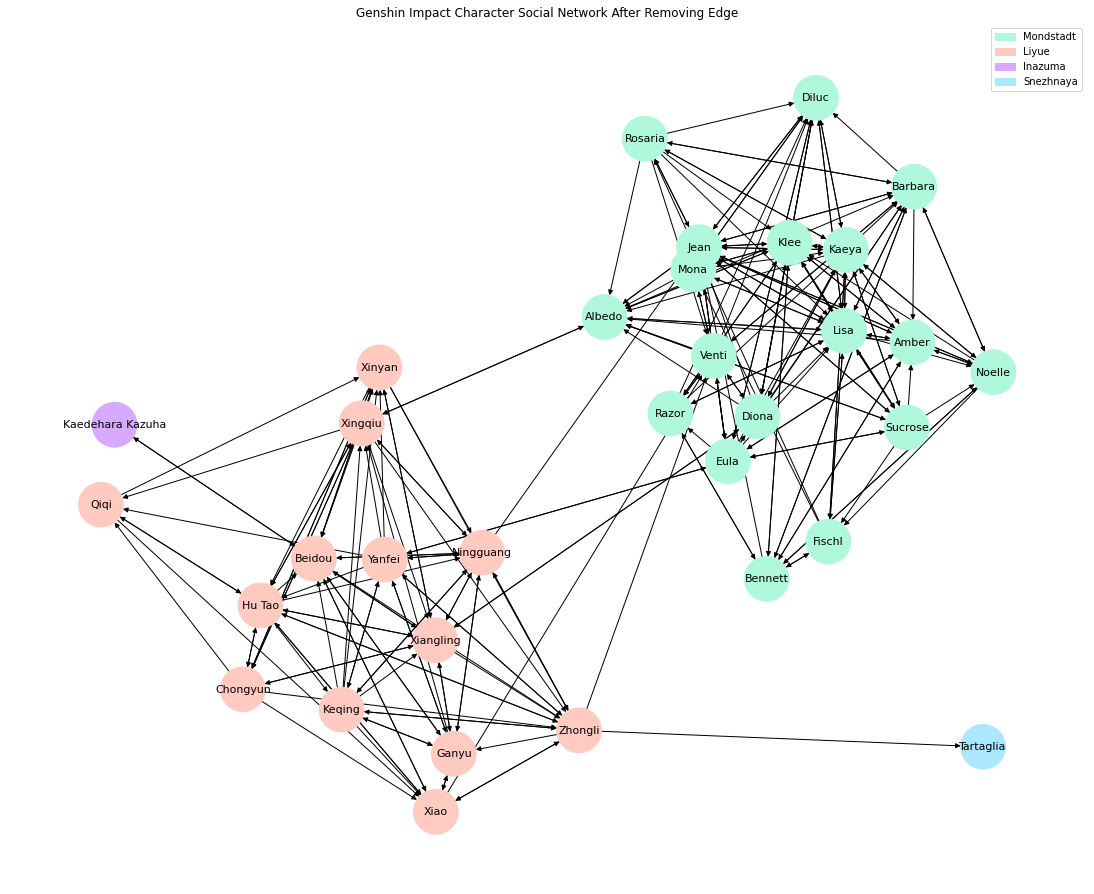

In [143]:
# create node color list for visualization
mutual_connected_node_colors = []
for node, nation in list(temp_copy.nodes(data="nation")):
    if nation in nation_color_dict:
        mutual_connected_node_colors.append(nation_color_dict[nation])
    else:
        mutual_connected_node_colors.append('#FFA500') # traveler doesn't belong to any nation
        
# create spring layout for 25 iterations to separate the nodes
pos = nx.spring_layout(temp_copy, k=0.5, iterations=25, seed=1)

plt.figure(1,figsize=(15,12)) 
nx.draw(temp_copy,
        pos = pos,
        node_size=2000,
        node_color=mutual_connected_node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend and show the plot
legend_tiles = [mpatches.Patch(color="#aff8db", label="Mondstadt"),
                mpatches.Patch(color="#ffcbc1", label="Liyue"),
                mpatches.Patch(color="#d5aaff", label="Inazuma"),
                mpatches.Patch(color="#ace7ff", label="Snezhnaya")
               ]

plt.title("Genshin Impact Character Social Network After Removing Edge")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()
# uncomment to save picture
# plt.savefig('directed.png')

### After removing the directed edge connected from Tartaglia to Zhongli, the directed network is disconnected.